In [232]:
import pandas as pd
import numpy as np

purchasing = pd.read_csv('original_data/Purchasing_Tool_FY16-FY18_2018-11-16.csv')
expo = pd.read_csv('original_data/Expo_Archive_2018-11-16.csv')

print purchasing.columns
print expo.columns

Index([u'Supplier ID', u'PO', u'Line', u'Shipment', u'Release', u'StdCost',
       u'PoCost', u'BuyerNumber', u'BuyProgram', u'BuyerName', u'Part',
       u'Description', u'Qty', u'ReceiverNumber', u'SupplierID', u'Year',
       u'Period', u'Week', u'Qtr', u'CommodityLevel1', u'CommodityLevel2',
       u'CommodityLevel3', u'InternalCostSavings', u'Spend', u'ForecastType',
       u'PurchLeadTime', u'ABC', u'PaymentTerm', u'SupplierClassification',
       u'Category', u'PoPlacedDate', u'PoPlacedYear', u'Org_Code',
       u'SupplierSite'],
      dtype='object')
Index([u'Supplier ID', u'PO Number', u'Line', u'Schedule', u'Revision',
       u'Confirmed Dock Date', u'Part Number', u'Part Description',
       u'Part Revision', u'Performance Date', u'Supplier Due Date',
       u'Need Date', u'Order Date', u'Message', u'Qty Open', u'Unit Price',
       u'Extended Price', u'Critical', u'VMI', u'Date Modified', u'Comments',
       u'Harris Comments', u'Shipments', u'Business Unit Code'],
      dt

In [233]:
# save dataframe with part number and category

category = pd.DataFrame()

category['Part Number'] = purchasing['Part']
category['Category'] = purchasing['Category']

category = category.drop_duplicates(subset = ['Part Number'])
category = category.dropna()

In [234]:
# drop irrelevant features

purchasing = purchasing.drop(['SupplierID', 'Shipment', 'PO', 'Line', 'Release','BuyerNumber', 'BuyProgram', 'BuyerName', 'Description', 'ReceiverNumber',
                'Year', 'Period', 'Week', 'Qtr', 'CommodityLevel1', 'CommodityLevel2', 'CommodityLevel3',
                'ForecastType', 'PaymentTerm', 'SupplierClassification', 'PoPlacedDate', 'PoPlacedYear',
                'Org_Code', 'SupplierSite'], axis = 1)

expo = expo.drop(['Revision', 'Part Description', 'PO Number', 'Line', 'Schedule', 'Revision','Part Revision', 'Supplier Due Date', 'Message', 'Qty Open', 'Unit Price',
          'Extended Price', 'VMI', 'Date Modified', 'Comments', 'Harris Comments', 'Shipments', 'Business Unit Code']
         , axis =1)


In [235]:
# fix dates in expo

from datetime import datetime as dt
def convert_to_date(s):
    try: 
        return dt.date(dt.strptime(str(s)[:10], '%Y-%M-%d'))
    except (TypeError, ValueError) as e:
        return (pd.NaT)
    
def convert_to_date2(s):
    try:
        return dt.date(dt.strptime(str(s), '%m/%d/%Y'))
    except (TypeError, ValueError) as e:
        return (pd.NaT)
    
expo['Confirmed Dock Date'] = expo['Confirmed Dock Date'].apply(convert_to_date2)
expo['Performance Date'] = expo['Performance Date'].apply(convert_to_date)
expo['Need Date'] = expo['Need Date'].apply(convert_to_date)
expo['Order Date'] = expo['Order Date'].apply(convert_to_date)


In [236]:
# drop na in expo except in schedule

print expo.count()

expo = expo.dropna()
expo = expo.reset_index(drop = True)

Supplier ID            112819
Confirmed Dock Date     83646
Part Number             92442
Performance Date       113194
Need Date              109062
Order Date             113194
Critical               113194
dtype: int64


In [237]:
# engineer late and early columns in expo

expo['temp_Late'] =  expo['Performance Date'] - expo['Confirmed Dock Date']
expo['temp_Late'] = expo['temp_Late'].astype('timedelta64[D]')

expo['Late'] = [i if i > 0 else 0 for i in expo['temp_Late']]
expo['Early'] = [abs(i) if i < 0 else 0 for i in expo['temp_Late']]

del expo['temp_Late']

In [238]:
# drop nas from purchasing tool

print purchasing.count()

purchasing = purchasing.dropna()
purchasing = purchasing.reset_index(drop = True)

Supplier ID            135181
StdCost                135181
PoCost                 135181
Part                   132601
Qty                    135181
InternalCostSavings    135181
Spend                  135181
PurchLeadTime          135181
ABC                    131482
Category               135181
dtype: int64


In [239]:
# fix purchase lead time codes

purch_lead_time_dict = {240:183, 299:365 ,999:365, 365:274, 364:274, 350:274}
purchasing['PurchLeadTime'] = [purch_lead_time_dict[i] if i in purch_lead_time_dict.keys() else i for i in purchasing['PurchLeadTime']]

In [240]:
# create return spend and return quantity columns. Zero out negatives in spend  and qty
# transaction_type is 0 = return, 1 = order

purchasing['transaction_type'] = [0 if d < 0 else 1 for d in purchasing['Spend']]

purchasing['Return_spend'] = [0 if d >= 0 else abs(d) for d in purchasing['Spend']]
purchasing['Spend'] = [d if d >= 0 else 0 for d in purchasing['Spend']]
                       
purchasing['Return_qty'] = [0 if d >= 0 else abs(d) for d in purchasing['Qty']]
purchasing['Qty'] = [d if d >= 0 else 0 for d in purchasing['Qty']]

In [241]:
# add single/multi source column to p_tool as 'Source'.

source = pd.DataFrame()

source['Source'] = purchasing.groupby(['Part'])['Supplier ID'].apply(lambda x: x.drop_duplicates().count())
#source['Source'] = [1 if (d == 1) else 0 for d in source['Source']]
source['Part'] = source.index
source.index = range(len(source))

purchasing = purchasing.merge(source, on = ['Part'], how = 'left')

In [242]:
# transform ABC column in purchasing

ABC_dict = {'A':0.7, 'B':0.5, 'C':0.3}
purchasing['ABC'] = [ABC_dict[d] for d in purchasing['ABC']]

In [243]:
# drop early/late outliers

expo = expo.drop(list(expo[expo['Late'] > 500].index), axis = 0)
expo = expo.drop(list(expo[expo['Early'] > 500].index), axis = 0)
expo = expo.reset_index(drop = True)

In [244]:
print purchasing.count()
print expo.count()

Supplier ID            131482
StdCost                131482
PoCost                 131482
Part                   131482
Qty                    131482
InternalCostSavings    131482
Spend                  131482
PurchLeadTime          131482
ABC                    131482
Category               131482
transaction_type       131482
Return_spend           131482
Return_qty             131482
Source                 131482
dtype: int64
Supplier ID            72327
Confirmed Dock Date    72327
Part Number            72327
Performance Date       72327
Need Date              72327
Order Date             72327
Critical               72327
Late                   72327
Early                  72327
dtype: int64


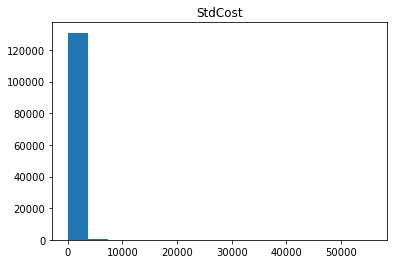

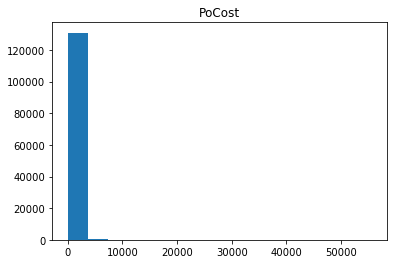

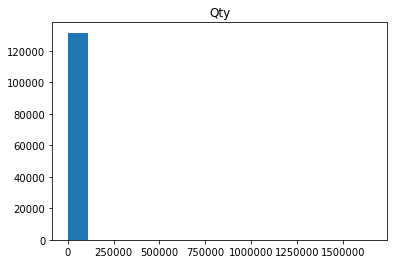

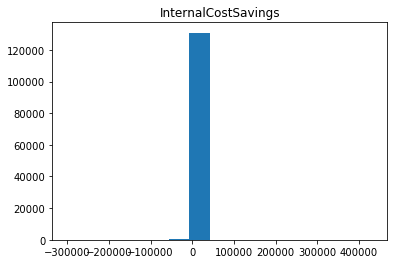

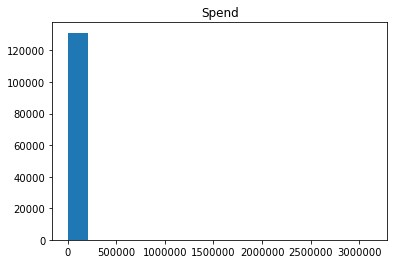

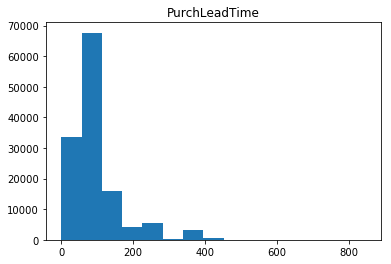

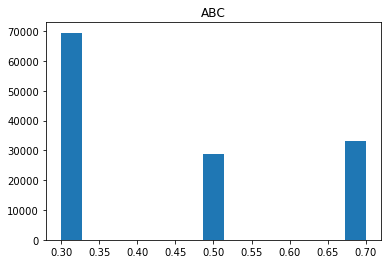

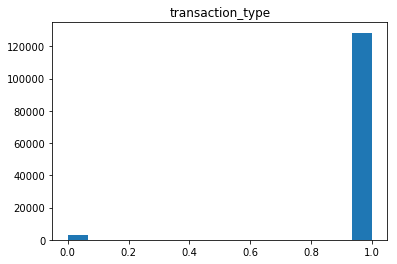

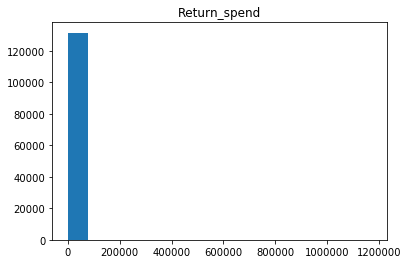

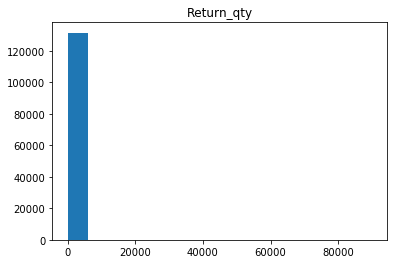

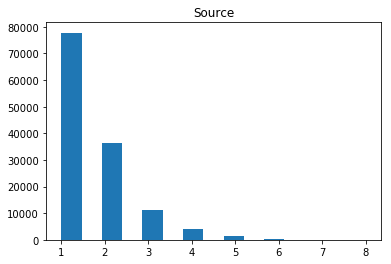

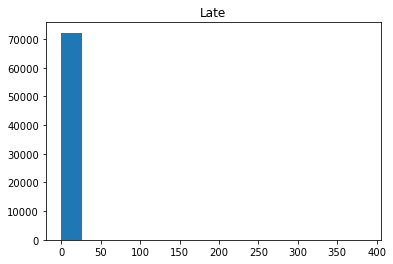

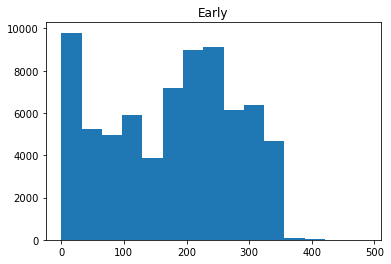

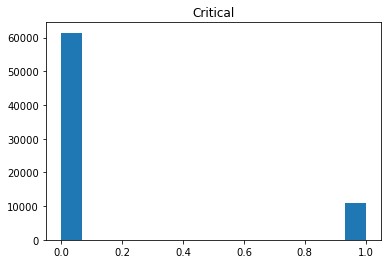

In [245]:
import matplotlib.pyplot as plt
import numpy as np
import math

p_features = ['StdCost', 'PoCost', 'Qty',
           'InternalCostSavings', 'Spend', 'PurchLeadTime', 'ABC',  
            'transaction_type', 'Return_spend', 'Return_qty', 'Source']

e_features = ['Late', 'Early', 'Critical']

for feat in p_features:
    plt.hist(purchasing[feat], bins = 15)
    plt.title(feat)
    plt.xlabel = ("Value")
    plt.ylabel = ("Count")
    #fname = "distr/" + feat + "_distr"
    #plt.savefig(fname)
    plt.show()
    
for feat in e_features:
    plt.hist(expo[feat], bins = 15)
    plt.title(feat)
    plt.xlabel = ("Value")
    plt.ylabel = ("Count")
    #fname = "distr/" + feat + "_distr"
    #plt.savefig(fname)
    plt.show()


In [246]:
#bins 

# purchasing
def bin_purchasing(d):
    data = d.copy()
    data['StdCost'] = pd.to_numeric(pd.cut(data['StdCost'], bins = [-1,1,5,50,100,10000000], labels = [1,2,3,4,5]))
    data['PoCost'] = pd.to_numeric(pd.cut(data['PoCost'], bins = [-1,1,5,50,100,10000000], labels = [1,2,3,4,5]))
    data['Qty'] = pd.to_numeric(pd.cut(data['Qty'], bins = [-1,50,150,500,5000,10000000], labels = [1,2,3,4,5]))
    data['InternalCostSavings'] = pd.to_numeric(pd.cut(data['InternalCostSavings'], 
                                         bins = [-1000000,-100,-10,0,10,10000000], labels = [5,4,3,2,1]))
    data['Spend'] = pd.to_numeric(pd.cut(data['Spend'], bins = [-1,2500,10000,50000,100000,100000000], 
                                         labels = [1,2,3,4,5]))
    data['PurchLeadTime'] = pd.to_numeric(pd.cut(data['PurchLeadTime'], 
                                   bins = [-1,50,125,225,350,10000], labels = [1,2,3,4,5]))
    data['ABC'] = pd.to_numeric(pd.cut(data['ABC'], bins = [0,0.4,0.6,1], labels = [1,3,5]))
    data['transaction_type'] = pd.to_numeric(pd.cut(data['transaction_type'], bins = [-0.5,0.5,2], labels = [5,1]))
    data['Return_spend'] = pd.to_numeric(pd.cut(data['Return_spend'], 
                                                bins = [-1,2500,10000,50000,100000,100000000], labels = [1,2,3,4,5]))
    data['Return_qty'] = pd.to_numeric(pd.cut(data['Return_qty'], 
                                              bins = [-1,50,150,500,5000,10000000], labels = [1,2,3,4,5]))
    data['Source'] = pd.to_numeric(pd.cut(data['Source'], bins = [-1,1.1,3.1,10], labels = [5,2,1]))

    return data

def bin_expo(d):
    data = d.copy()
    data['Late_bin'] = pd.to_numeric(pd.cut(data['Late'], bins = [-1,0.5,3,10,20,1000], labels = [1,2,3,4,5]))
    data['Early_bin'] = pd.to_numeric(pd.cut(data['Early'], bins = [-1,0.5,3,10,20,1000], labels = [1,2,3,4,5]))
    return data

In [247]:
purch_binned = bin_purchasing(purchasing)
expo_binned = bin_expo(expo)

print purch_binned.count()
print expo_binned.count()

Supplier ID            131482
StdCost                131482
PoCost                 131482
Part                   131482
Qty                    131482
InternalCostSavings    131482
Spend                  131482
PurchLeadTime          131482
ABC                    131482
Category               131482
transaction_type       131482
Return_spend           131482
Return_qty             131482
Source                 131482
dtype: int64
Supplier ID            72327
Confirmed Dock Date    72327
Part Number            72327
Performance Date       72327
Need Date              72327
Order Date             72327
Critical               72327
Late                   72327
Early                  72327
Late_bin               72327
Early_bin              72327
dtype: int64


In [248]:
# aggregate purchasing


def purchasing_aggregate(data, groupby):
    aggregate = pd.DataFrame()
    
    aggregate['mean_stdcost'] = data.groupby(groupby)['StdCost'].mean()
    aggregate['median_stdcost'] = data.groupby(groupby)['StdCost'].median()
    #aggregate['var_stdcost'] = data.groupby(groupby)['StdCost'].var()

    aggregate['mean_pocost'] = data.groupby(groupby)['PoCost'].mean()
    aggregate['median_pocost'] = data.groupby(groupby)['PoCost'].median()
    #aggregate['var_log_pocost'] = data.groupby(groupby)['PoCost'].var()
    
    aggregate['mean_qty'] = data.groupby(groupby)['Qty'].mean()
    aggregate['median_qty'] = data.groupby(groupby)['Qty'].median()
    #aggregate['var_log_qty'] = data.groupby(groupby)['Qty'].var()
    
    aggregate['mean_return_qty'] = data.groupby(groupby)['Return_qty'].mean()
    aggregate['median_return_qty'] = data.groupby(groupby)['Return_qty'].median()
    #aggregate['var_log_return_qty'] = data.groupby(groupby)['Return_qty'].var()
    
    aggregate['mean_costsave'] = data.groupby(groupby)['InternalCostSavings'].mean()
    aggregate['median_costsave'] = data.groupby(groupby)['InternalCostSavings'].median()
    #aggregate['var_log_costsave'] = data.groupby(groupby)['InternalCostSavings'].var()
    
    aggregate['mean_spend'] = data.groupby(groupby)['Spend'].mean()
    aggregate['median_spend'] = data.groupby(groupby)['Spend'].median()
    #aggregate['var_log_spend'] = data.groupby(groupby)['Spend'].var()

    aggregate['mean_return_spend'] = data.groupby(groupby)['Return_spend'].mean()
    aggregate['median_return_spend'] = data.groupby(groupby)['Return_spend'].median()
    #aggregate['var_log_return_spend'] = data.groupby(groupby)['Return_spend'].var()
    
    aggregate['mean_leadtime'] = data.groupby(groupby)['PurchLeadTime'].mean()
    aggregate['median_leadtime'] = data.groupby(groupby)['PurchLeadTime'].median()
    #aggregate['variance_log_leadtime'] = data.groupby(groupby)['PurchLeadTime'].var()
    
    aggregate['mean_abc'] = data.groupby(groupby)['ABC'].mean()
    aggregate['median_abc'] = data.groupby(groupby)['ABC'].median()

    
    aggregate['mean_source'] = data.groupby(groupby)['Source'].mean()
    aggregate['median_source'] = data.groupby(groupby)['Source'].median()


    aggregate['num_orders_purch'] = data.groupby(groupby)['transaction_type'].apply(lambda x: x[x == 1].count())
    aggregate['num_returns_purch'] = data.groupby(groupby)['transaction_type'].apply(lambda x: x[x == 5].count())

    
    aggregate['Supplier ID'] = aggregate.index
    aggregate.index = range(len(aggregate))
    
    if 'Category' in groupby:
        aggregate['Category'] = [d[1] for d in aggregate['Supplier ID']]
        aggregate['Supplier ID'] = [d[0] for d in aggregate['Supplier ID']]
    
    return aggregate


In [249]:
# aggregate expo

def expo_aggregate(data, groupby):
    new_expo = pd.DataFrame()
    
    new_expo['mean_late'] = data.groupby(groupby)['Late_bin'].mean()
    new_expo['median_late'] = data.groupby(groupby)['Late_bin'].median()

    new_expo['mean_early'] = data.groupby(groupby)['Early_bin'].mean()
    new_expo['median_early'] = data.groupby(groupby)['Early_bin'].mean()



    new_expo['num_late'] = data.groupby(groupby)['Late'].apply(lambda x: x[x > 0].count())
    new_expo['num_early'] = data.groupby(groupby)['Early'].apply(lambda x: x[x > 0].count())
    new_expo['num_critical'] = data.groupby(groupby)['Critical'].apply(lambda x: x[x == True].count())
    new_expo['num_transactions_expo'] = data.groupby(groupby)['Late'].count()


    new_expo['%_late'] = new_expo['num_late'] / new_expo['num_transactions_expo']
    new_expo['%_early'] = new_expo['num_early'] / new_expo['num_transactions_expo']
    new_expo['%_critical'] = new_expo['num_critical'] / new_expo['num_transactions_expo']

    new_expo = new_expo.drop(['num_late'], axis=1)
    new_expo = new_expo.drop(['num_early'], axis=1)
    new_expo = new_expo.drop(['num_critical'], axis=1)


    new_expo['Supplier ID'] = new_expo.index
    new_expo.index = range(len(new_expo))
    
    if 'Category' in groupby:
        new_expo['Category'] = [d[1] for d in new_expo['Supplier ID']]
        new_expo['Supplier ID'] = [d[0] for d in new_expo['Supplier ID']]
    
    return new_expo

In [250]:
# append 'Category' to expo

expo_binned_aug = expo_binned.merge(category, on = ['Part Number'], how = 'left')
expo_binned_aug = expo_binned_aug.dropna()

In [251]:
agg_purch = purchasing_aggregate(purch_binned, ['Supplier ID', 'Category'])

agg_expo = expo_aggregate(expo_binned_aug, ['Supplier ID', 'Category'])

print agg_purch.count()
print agg_expo.count()


mean_stdcost           1015
median_stdcost         1015
mean_pocost            1015
median_pocost          1015
mean_qty               1015
median_qty             1015
mean_return_qty        1015
median_return_qty      1015
mean_costsave          1015
median_costsave        1015
mean_spend             1015
median_spend           1015
mean_return_spend      1015
median_return_spend    1015
mean_leadtime          1015
median_leadtime        1015
mean_abc               1015
median_abc             1015
mean_source            1015
median_source          1015
num_orders_purch       1015
num_returns_purch      1015
Supplier ID            1015
Category               1015
dtype: int64
mean_late                749
median_late              749
mean_early               749
median_early             749
num_transactions_expo    749
%_late                   749
%_early                  749
%_critical               749
Supplier ID              749
Category                 749
dtype: int64


In [252]:
# second round of binning for expo

def bin_expo2(d):
    data = d.copy()
    data['%Late'] = pd.to_numeric(pd.cut(data['%_late'], bins = [-1,0.2,0.4,0.6,0.8,1.1], labels = [1,2,3,4,5]))
    data['%Early'] = pd.to_numeric(pd.cut(data['%_early'], bins = [-1,0.2,0.4,0.6,0.8,1.1], labels = [1,2,3,4,5]))
    data['%Critical'] = pd.to_numeric(pd.cut(data['%_critical'], bins = [-1,0.2,0.4,0.6,0.8,1.1], labels = [1,2,3,4,5]))
    return data

In [253]:
agg_expo_bin = bin_expo2(agg_expo)

del agg_expo_bin['%_late']
del agg_expo_bin['%_early']
del agg_expo_bin['%_critical']


In [254]:
# join

join = agg_purch.merge(agg_expo_bin, on = ['Supplier ID', 'Category'], how = 'inner')

print join.count()

join.head()

mean_stdcost             594
median_stdcost           594
mean_pocost              594
median_pocost            594
mean_qty                 594
median_qty               594
mean_return_qty          594
median_return_qty        594
mean_costsave            594
median_costsave          594
mean_spend               594
median_spend             594
mean_return_spend        594
median_return_spend      594
mean_leadtime            594
median_leadtime          594
mean_abc                 594
median_abc               594
mean_source              594
median_source            594
num_orders_purch         594
num_returns_purch        594
Supplier ID              594
Category                 594
mean_late                594
median_late              594
mean_early               594
median_early             594
num_transactions_expo    594
%Late                    594
%Early                   594
%Critical                594
dtype: int64


,mean_stdcost,median_stdcost,mean_pocost,median_pocost,mean_qty,median_qty,mean_return_qty,median_return_qty,mean_costsave,median_costsave,...,Supplier ID,Category,mean_late,median_late,mean_early,median_early,num_transactions_expo,%Late,%Early,%Critical
0,2.250000,2.0,2.000000,2.0,2.937500,3.0,1.375000,1.0,3.750000,5.0,...,S002,Fabrication,1.0,1,5.0,5.0,10,1,5,1
1,3.000000,3.0,3.000000,3.0,2.357143,2.0,1.000000,1.0,3.142857,3.0,...,S006,Cable/Conn/Wire,1.0,1,5.0,5.0,6,1,5,1
2,4.888889,5.0,4.888889,5.0,1.888889,1.0,1.000000,1.0,2.222222,2.0,...,S008,Accessories/OEM,1.0,1,5.0,5.0,9,1,5,2
3,2.894737,3.0,2.894737,3.0,2.771930,3.0,1.087719,1.0,3.421053,3.0,...,S010,Fabrication,1.0,1,5.0,5.0,1,1,5,5
4,2.735294,3.0,2.794118,3.0,1.970588,2.0,1.176471,1.0,3.411765,5.0,...,S012,Raw PCB,1.0,1,4.8,4.8,20,1,5,1


In [255]:
join.to_csv("join.csv", index = False)
